# Interface Context

The `InterfaceContext` class is used to extract cells within the interface of two or more given tissues. Here we will use it to extract the tumor-stroma interfaces and the cells within them.

After fititng the context, The `InterfaceContext.context` attribute will contain a nested dict where each value is a dict contain the following key-value pairs:

- `roi_area` - the roi areas of type `top_labels` (`gpd.GeoDataFrame`)
- `roi_cells` - the cells inside the roi areas. (`gpd.GeoDataFrame`)
- `roi_grid` - the grids fitted on top of the roi areas of type `top_labels`. (`gpd.GeoDataFrame`)
- `interface_area` - returns the interface areas between `top_labels` and `bottom_labels` areas (`gpd.GeoDataFrame`)
- `interface_cells` - returns the cells inside the `interface_area`. (`gpd.GeoDataFrame`)
- `interface_grid` - returns the grids fitted on top of the interface areas. (`gpd.GeoDataFrame`)
- `full_network` - the network fitted on the union of `interface_cells` and `roi_cells`. (`libpysal.weights.W`)
- `roi_network` - the network fitted on the `roi_cells`. (`libpysal.weights.W`)
- `interface_network` - returns the network fitted on top of the `interface_cells`. (`libpysal.weights.W`)
- `border_network` - returns the network fitted on top of the cells that cross the interface border. (`libpysal.weights.W`)

## The Data

A quick sneak peak into the data.

In [1]:
from cellseg_gsontools.data import cervix_cells

# sneak peak to the data that will be used in the notebook
cervix_cells().head()

,type,geometry,class_name
uid,,,
1,Feature,"POLYGON ((-10.988 48446.005, -10.988 48453.996...",inflammatory
2,Feature,"POLYGON ((-20.988 48477.996, -19.990 48479.993...",connective
3,Feature,"POLYGON ((-14.988 48767.995, -11.993 48770.990...",inflammatory
4,Feature,"POLYGON ((-3.988 49537.995, -2.995 49538.988, ...",connective
5,Feature,"POLYGON ((-7.988 49562.995, -5.995 49564.988, ...",connective


In [2]:
from cellseg_gsontools.data import cervix_tissue

cervix_tissue().head()

,type,geometry,class_name
uid,,,
1,Feature,"POLYGON ((1852.953 51003.603, 1853.023 51009.1...",areastroma
2,Feature,"POLYGON ((4122.334 48001.899, 4122.994 48014.8...",areagland
3,Feature,"POLYGON ((3075.002 48189.068, 3075.001 48218.8...",areagland
4,Feature,"POLYGON ((51.106 50822.418, 57.151 50834.504, ...",areagland
5,Feature,"POLYGON ((3150.958 52999.764, 3147.245 52996.5...",areastroma


## Fitting the Context

In [3]:
from cellseg_gsontools.spatial_context import InterfaceContext

icsp = InterfaceContext(
    area_gdf=cervix_tissue(),
    cell_gdf=cervix_cells(),
    top_labels="area_cin",  # tissue classes that are buffered on top of bottom_labels
    bottom_labels="areastroma",  # tissue classes that are being buffered on
    buffer_dist=250.0,  # the distance to buffer top_labels on top of bottom_labels
    min_area_size=100000,  # minimum area size of the top_labels (in pixels**2)
    silence_warnings=True,
    parallel=False,  # Whether to run in parallel
    num_processes=1,  # Number of processes to use
    graph_type="distband",  # Use a distance band graph (distance thresholded KNN-graph)
    dist_thresh=90,  # Distance threshold for the graph
    backend="geopandas",  # Use geopandas for fitting
    grid_type="hex",  # Use a hexagonal grid
    resolution=10,  # Resolution of the grid
)
icsp.fit(fit_graph=True, fit_grid=True)

Processing roi area: 3: 100%|██████████| 4/4 [00:00<00:00,  5.72it/s]


In [4]:
# Cells of the first interface
icsp.context[0]["interface_cells"].head()

,type_left,geometry,class_name,global_id,spatial_context_id,type_right,spatial_context
global_id,,,,,,,
9098,Feature,"POLYGON ((7933.01182 49512.00490, 7933.01188 4...",inflammatory,9098,0,Feature,areastroma
9109,Feature,"POLYGON ((7921.01188 49532.00360, 7921.01188 4...",inflammatory,9109,0,Feature,areastroma
9114,Feature,"POLYGON ((7961.01182 49532.00490, 7961.01188 4...",inflammatory,9114,0,Feature,areastroma
9139,Feature,"POLYGON ((7925.01188 49559.99640, 7926.01013 4...",inflammatory,9139,0,Feature,areastroma
9167,Feature,"POLYGON ((7968.01191 49600.00298, 7969.01095 4...",inflammatory,9167,0,Feature,areastroma


## Plotting the Interfaces

Let's plot the extracted interfaces and cells.

<Axes: >

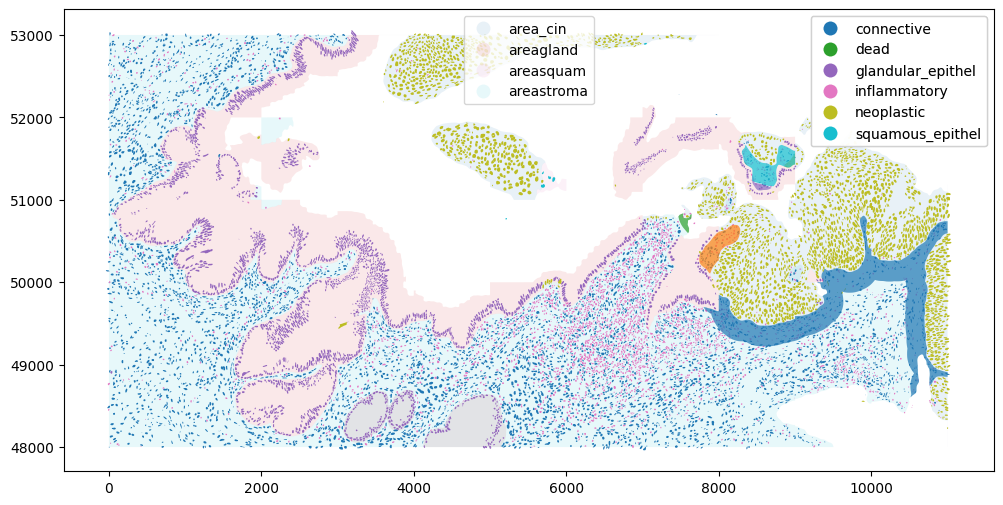

In [5]:
icsp.plot("interface_area", figsize=(12, 6))

We can also plot the graphs that are fitted to the cells in different contexts. Here, we will plot the graphs fitted to the cells that cross the interface i.e. the `border_network`. With the `border_network`, we can count the cell-cell connections that cross the border of the two tissues to see whether, for example, there is any immune infiltration from stroma to tumor.

<Axes: >

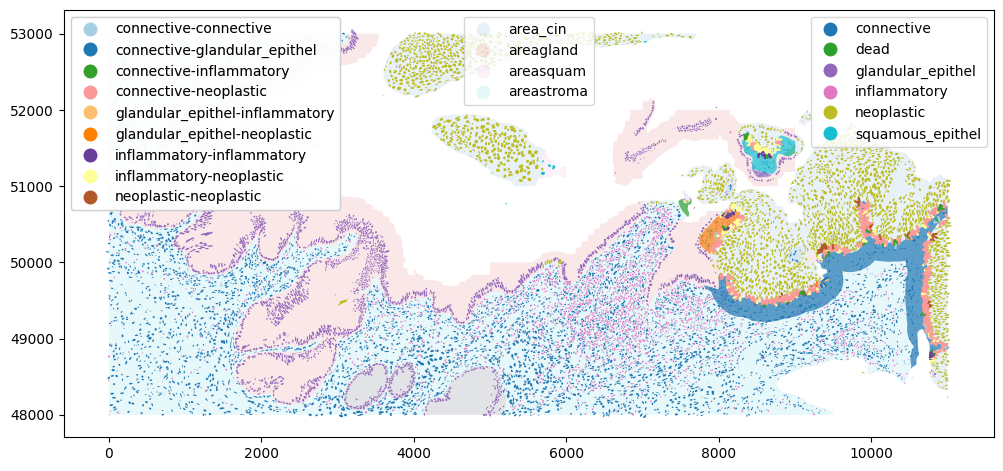

In [6]:
icsp.plot("interface_area", network_key="border_network", figsize=(12, 6))

<Axes: >

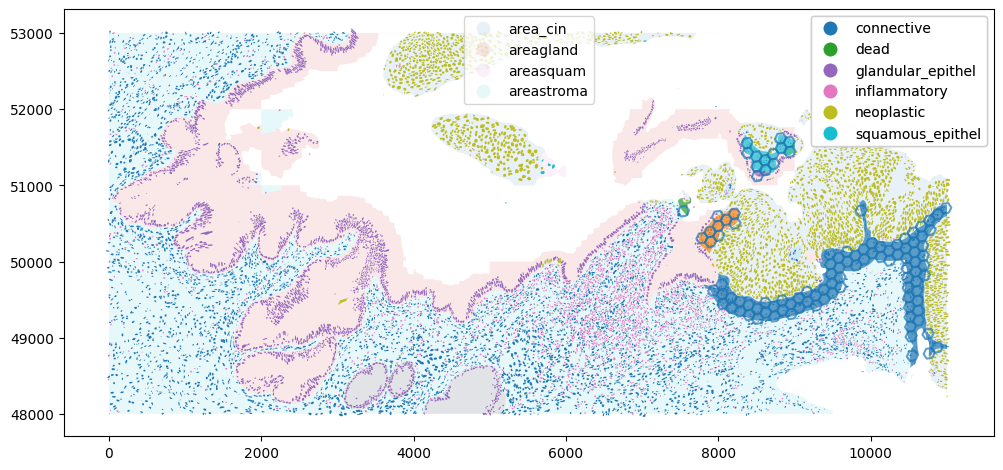

In [7]:
icsp.plot("interface_area", grid_key="interface_grid", figsize=(12, 6))

## Downstream Analysis
Now that we’ve fitted the context, we can use the interfaces in the `context` class attribute to compute more features. Here, we will showcase some lightweight downstream analyses for the extracted interfaces.

### Example 1: Immune Infiltration Density
Here we compute the density of the inflammatory cells at the interface that have links to neoplastic cells at the tumor. We will use the `interface_grid` of the context and compute the link count of the inflammatory-neoplastic links within the grid cells to do this.

<Axes: >

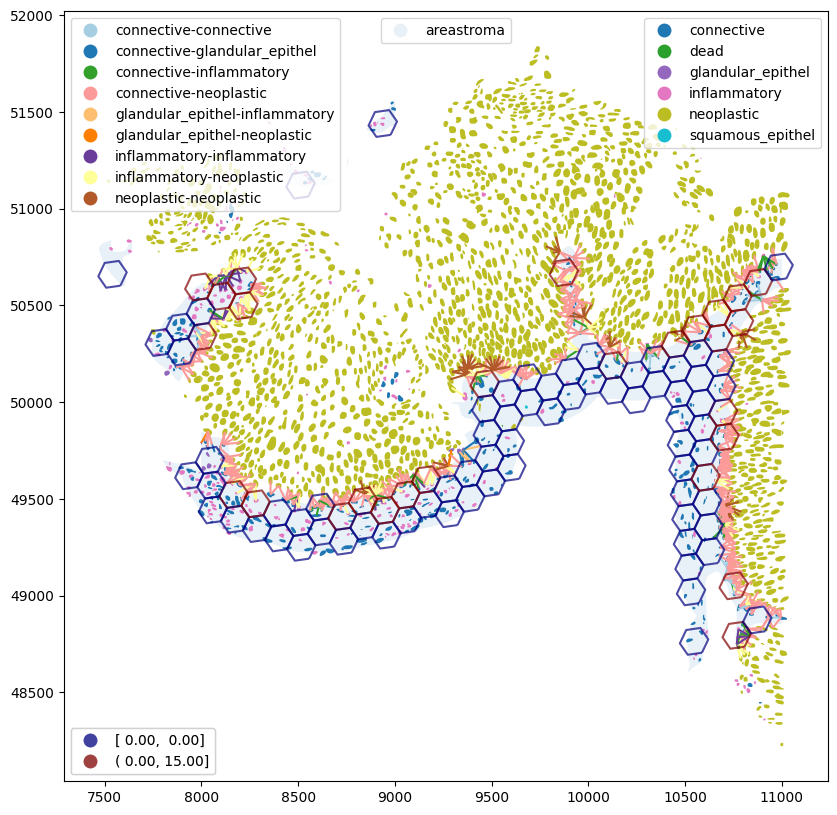

In [8]:
import geopandas as gpd
import mapclassify
import numpy as np
import pandas as pd

from cellseg_gsontools.grid import grid_classify
from cellseg_gsontools.links import weights2gdf
from cellseg_gsontools.plotting import plot_all


# helper function to replace legend items
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k, v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)


# Immune-neoplastic link cnt heuristic to classify the grid cells into two classes
def get_infiltration_cnt(gdf: gpd.GeoDataFrame, **kwargs) -> float:
    dd = np.array(["inflammatory-neoplastic", "neoplastic-inflammatory"])

    try:
        class_name = dd[
            np.array([cl in gdf.class_name.unique().tolist() for cl in dd])
        ][0]
        cnt = gdf.class_name.value_counts()[class_name]
    except Exception:
        cnt = 0

    return int(cnt)


# get the border network and convert it to a gdf
w = icsp.context[0]["border_network"]
link_gdf = weights2gdf(icsp.cell_gdf, w)

# Count the immune cells within the grid cells with the cell cnt heuristic
iface_grid = grid_classify(
    grid=icsp.context[0]["interface_grid"],
    objs=link_gdf,
    metric_func=get_infiltration_cnt,
    predicate="intersects",
    new_col_names="infiltrate_cnt",
    parallel=False,
)

# bin the grid cells into two classes ("has infiltration" and "no infiltration")
col = "infiltrate_cnt"
bins = mapclassify.Quantiles(iface_grid[col], k=2)
iface_grid["infiltrate_density_level"] = bins.yb

immune_density_plot = plot_all(
    icsp.context[0]["interface_area"],
    pd.concat([icsp.context[0]["roi_cells"], icsp.context[0]["interface_cells"]]),
    grid_gdf=iface_grid.copy(),
    network_gdf=link_gdf.copy(),
    figsize=(10, 10),
    grid_col="infiltrate_density_level",
    grid_cmap="jet",
    grid_n_bins=bins.k,
    show_legends=True,
)
mapping = dict([(i, s) for i, s in enumerate(bins.get_legend_classes())])
replace_legend_items(immune_density_plot.get_legend(), mapping)
immune_density_plot

### Example 2: Cell-Cell Interactions

We can also directly count the cell-cell interactions between the cells crossing the tissue border. We can do this by using the `border_network` key of the context.

In [9]:
from cellseg_gsontools.links import weights2gdf

w = icsp.context[0]["border_network"]
w_gdf = weights2gdf(icsp.cell_gdf, w)
w_gdf.head()

,index,focal,neighbor,weight,focal_centroid,neighbor_centroid,focal_class_name,neighbor_class_name,class_name,geometry
0,0,9315,10482,1.0,POINT (7999.222138714856 49789.40336456389),POINT (8033.742411090165 49850.15890484998),glandular_epithel,neoplastic,glandular_epithel-neoplastic,"LINESTRING (7999.222 49789.403, 8033.742 49850..."
1,1,9356,9395,1.0,POINT (7937.002202793094 50113.275934318786),POINT (7896.607546050848 50178.72364538605),neoplastic,connective,connective-neoplastic,"LINESTRING (7937.002 50113.276, 7896.608 50178..."
2,2,9372,9395,1.0,POINT (7958.532206571154 50144.25476695621),POINT (7896.607546050848 50178.72364538605),neoplastic,connective,connective-neoplastic,"LINESTRING (7958.532 50144.255, 7896.608 50178..."
3,3,9372,9408,1.0,POINT (7958.532206571154 50144.25476695621),POINT (7914.7260717517165 50204.87002012703),neoplastic,connective,connective-neoplastic,"LINESTRING (7958.532 50144.255, 7914.726 50204..."
4,6,9395,9404,1.0,POINT (7896.607546050848 50178.72364538605),POINT (7954.544809238641 50192.02208046518),connective,neoplastic,connective-neoplastic,"LINESTRING (7896.608 50178.724, 7954.545 50192..."


In [10]:
# cell-cell link counts
w_gdf.value_counts("class_name")

class_name
connective-neoplastic             565
inflammatory-neoplastic           147
neoplastic-neoplastic              74
connective-inflammatory            60
inflammatory-inflammatory          31
connective-connective              25
connective-glandular_epithel        4
glandular_epithel-inflammatory      3
glandular_epithel-neoplastic        2
Name: count, dtype: int64

### Example 3: Computing Neighborhood Statistics

Next we will compute some neighborhood statistics for the cells within the ROI and the interface. We will compute the simpson index over the different cell types in each cell neighborhood. The higher the simpson index of a cell neighborhood is, the more diverse it is in terms of cell types.

In [11]:
from cellseg_gsontools.diversity import local_diversity

w = icsp.context[0]["full_network"]
cells = pd.concat([icsp.context[0]["roi_cells"], icsp.context[0]["interface_cells"]])
cells = cells[
    [
        "geometry",
        "global_id",
        "class_name",
    ]
]
# compute the heterogeneity of the neighborhood areas
cells = local_diversity(
    cells,
    spatial_weights=w,
    val_col="class_name",
    id_col="global_id",
    metrics=["simpson_index"],
    rm_nhood_cols=False,
)

cols = cols = [
    "geometry",
    "class_name",
    "nhood",
    "class_name_nhood_counts",
    "class_name_simpson_index",
]
cells[cols].head()

,geometry,class_name,nhood,class_name_nhood_counts,class_name_simpson_index
global_id,,,,,
9316,"POLYGON ((7992.01191 49918.00298, 7992.01191 4...",neoplastic,"[9316, 10482, 10496, 10508, 10516, 10528]",[6],0.000000
9323,"POLYGON ((7968.01182 50003.00490, 7968.01191 5...",neoplastic,"[9323, 9329, 9689, 10528, 10551, 10561]",[6],0.000000
9329,"POLYGON ((7910.01182 50037.99510, 7911.00490 5...",neoplastic,"[9329, 9323, 9356]",[3],0.000000
9356,"POLYGON ((7928.01188 50114.00360, 7928.01188 5...",neoplastic,"[9356, 9329, 9357, 9372, 9404, 9690, 9395]","[6, 1]",0.244898
9357,"POLYGON ((7960.01182 50118.99510, 7962.82642 5...",neoplastic,"[9357, 9356, 9372, 9404, 9689, 9690, 10594, 10...",[9],0.000000


In [1]:
# !pip install legendgram

<Axes: >

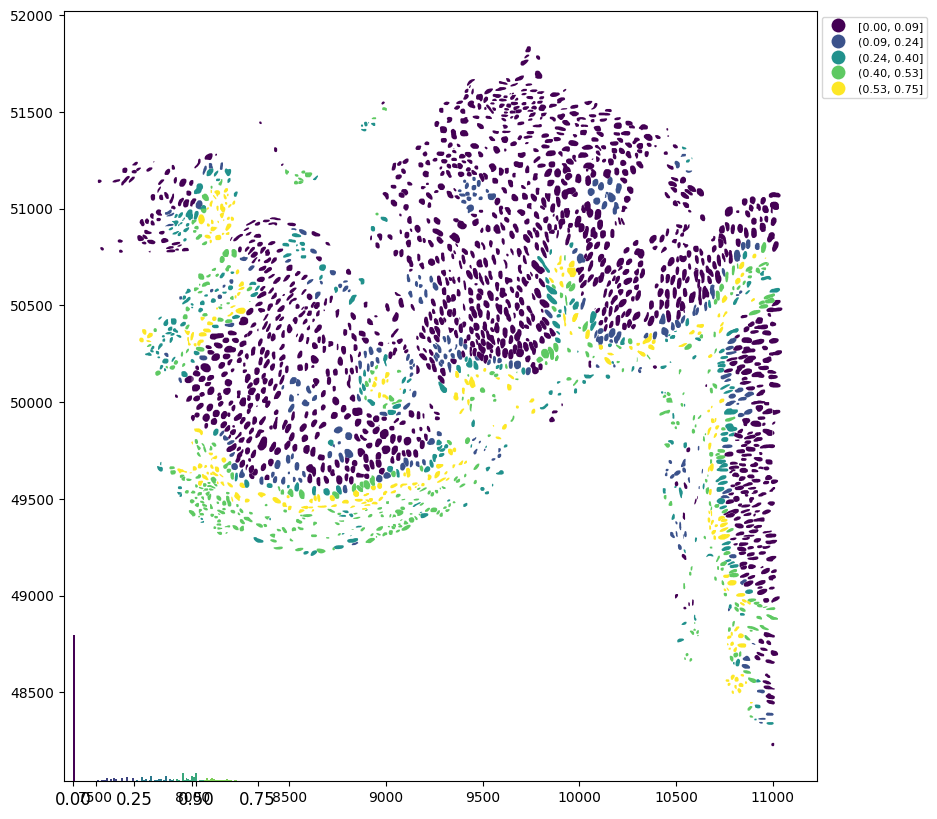

In [12]:
import matplotlib.pyplot as plt
import palettable as palet
from legendgram import legendgram


# Helper function to plot cells with a feature value highlighted
def plot_cells(cells: gpd.GeoDataFrame, col: str):
    # bin the values with the Fisher-Jenks method
    bins = mapclassify.FisherJenks(cells[col], k=5)
    cells["bin_vals"] = bins.yb

    # Let's plot the cells with the eccentricity metric
    f, ax = plt.subplots(figsize=(10, 10))

    ax = cells.plot(
        ax=ax,
        column="bin_vals",
        cmap="viridis",
        categorical=True,
        legend=True,
        legend_kwds={
            "fontsize": 8,
            "loc": "center left",
            "bbox_to_anchor": (1.0, 0.94),
        },
    )

    bin_legends = bins.get_legend_classes()
    mapping = dict([(i, s) for i, s in enumerate(bin_legends)])
    replace_legend_items(ax.get_legend(), mapping)

    ax = legendgram(
        f,
        ax,
        cells[col],
        bins=100,
        breaks=bins.bins,
        pal=palet.matplotlib.Viridis_5,
        loc="lower left",
    )

    return ax


# Let's plot the cells with the eccentricity metric
plot_cells(cells, col="class_name_simpson_index")

We can clearly see that the most diverse neighborhoods are located at
the interface border. This is expected since the interface border is
where the two tissues meet and on the other side there are tumor cells
and on the other side stromal and immune cells, meaning that the cells
at the border are likely to have more heterogenous neighboring cells.
Also, we see that the tumor cell neighborhoods are more homogenous than the cell neighborhoods in the stroma. This is also expected since tumors are normally homogenous mass of tumor cells with some tumor-infiltrating-lymphocytes here and there whereas in the stroma there are several different cell types present in a heterogenous mix.